# Multiple Linear Regression
## Bike Sharing Case Study

#### Problem Statement:

Bike Sharing company Boom Bikes have contracted a consulting company to understand the factors on which the demand for these shared bikes depends. Specifically, they want to understand the factors affecting the demand for these shared bikes in the American market. The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

**So interpretation is important!**

## Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [356]:
!pip show statsmodels

Name: statsmodels
Version: 0.12.2
Summary: Statistical computations and models for Python
Home-page: https://www.statsmodels.org/
Author: None
Author-email: None
License: BSD License
Location: /usr/local/lib/python3.7/dist-packages
Requires: patsy, scipy, pandas, numpy
Required-by: plotnine


In [357]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [358]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

Reusable Functions


In [359]:
def print_vif(df):
  # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
  vif = pd.DataFrame()
  vif['Features'] = df.columns
  vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [360]:
def build_model_print_statistics(X_train,y_train):
  #Build a linear model
  X_train_lm = sm.add_constant(X_train)
  model = sm.OLS(y_train, X_train_lm).fit()
  print(model.params)
  print(model.summary())
  return model,X_train_lm

Loading Data

In [361]:
bike = pd.read_csv("day.csv")

In [362]:
# Check the head of the dataset
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


Inspect the various aspects of the dataframe

In [363]:
bike.shape
# Inference - 730 Rows, 16 Columns

(730, 16)

In [364]:
bike.info()
# Inference - no null values. Imputing not needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [365]:
bike.describe()
# Inference 
# - Scaling needed for  temp, atemp, him, windspeed
# - Should holiday and weekday be converted to categorical and then to dummy variables?

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


Drop unnecessary columns
- instant - just index
- dteday - yr and month are available in separate columns, so not needed
- casual, registered - total count given by cnt column makes more sense than the casual and registered columns.

In [366]:
columns = ['instant','dteday','casual','registered']
bike = bike.drop(columns, axis=1)
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


Check for duplicates

In [367]:
bike_dup = bike.copy()

# Checking for duplicates and dropping the entire duplicate row if any
bike_dup.drop_duplicates(subset=None, inplace=True)
bike_dup.shape
# Inference
# - same value as original dataframe. So no duplicates.

(730, 12)

## Step 2: Visualising the Data

Let's now spend some time doing what is arguably the most important step - **understanding the data**.
- If there is some obvious multicollinearity going on, this is the first place to catch it
- Here's where you'll also identify if some predictors directly have a strong association with the outcome variable

We'll visualise our data using `matplotlib` and `seaborn`.

In [368]:
import matplotlib.pyplot as plt
import seaborn as sns

Plot numeric variables

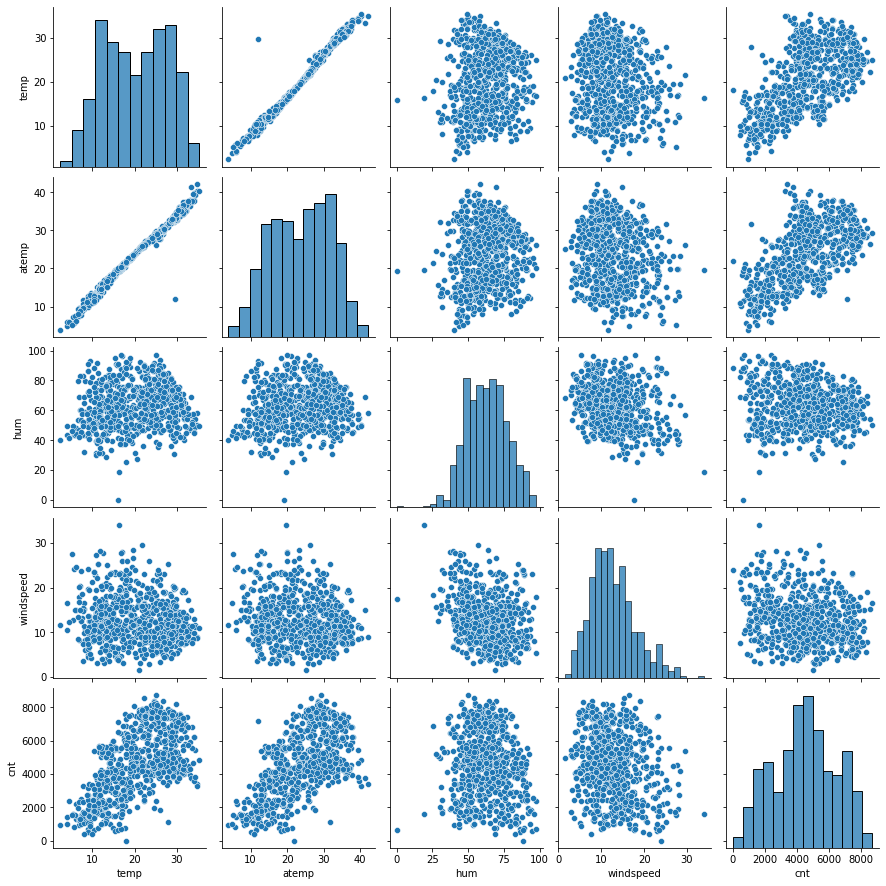

In [369]:
# pick only the relevant numeric variables and check
bike_num=bike[[ 'temp', 'atemp', 'hum', 'windspeed','cnt']]
sns.pairplot(bike_num)
plt.savefig('numerical')
plt.show()

Inference
- The pair plots tells us that there is a linear relationship between 
  - atemp and temp
  - atemp and cnt
  - temp and cnt

Plot categorical variables

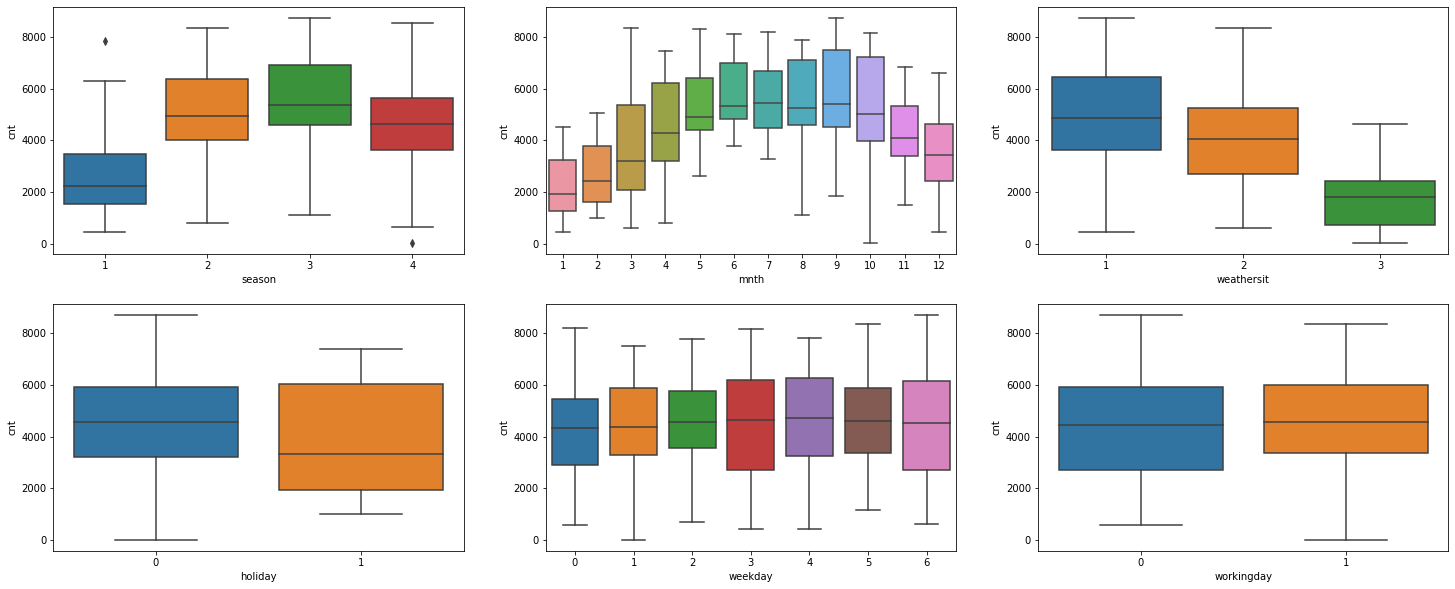

In [370]:
# Build boxplot of all categorical variables (before creating dummies) againt the target variable 'cnt' 

plt.figure(figsize=(25, 10))
plt.subplot(2,3,1)
sns.boxplot(x = 'season', y = 'cnt', data = bike)
plt.subplot(2,3,2)
sns.boxplot(x = 'mnth', y = 'cnt', data = bike)
plt.subplot(2,3,3)
sns.boxplot(x = 'weathersit', y = 'cnt', data = bike)
plt.subplot(2,3,4)
sns.boxplot(x = 'holiday', y = 'cnt', data = bike)
plt.subplot(2,3,5)
sns.boxplot(x = 'weekday', y = 'cnt', data = bike)
plt.subplot(2,3,6)
sns.boxplot(x = 'workingday', y = 'cnt', data = bike)
plt.savefig('categorical')
plt.show()

Inference
- Season
  - Season3 has the most bookings with highest median around 5000
  - It is clear that season affects the count. Hence it could be a predictor.
- Month
  - Mnth9 has the maximum bookings with a median of 5000
  - It is clear that mnth affects the count. Hence it could be a predictor.
- Weather situation
  - Weathersit1 has most bokkings with a median of 5000.
  - It is clear that Weathersit affects the count. Hence it could be a predictor.
- Holiday
  - when it is not a holiday, the median booking is higher. However, when it is a holiday, the 75th percentile is higher. Not sure. Will let the model decide if it is a good predictor.
- Weekday
  - Shows a pattern with median closely distributed.
  - Will let the model decide if it is a good predictor.
- Workingday
  - Workingday has higher median count than not a working day
  - It is clear that Workingday affects the count. Hence it could be a predictor.


Plot Correlation matrix

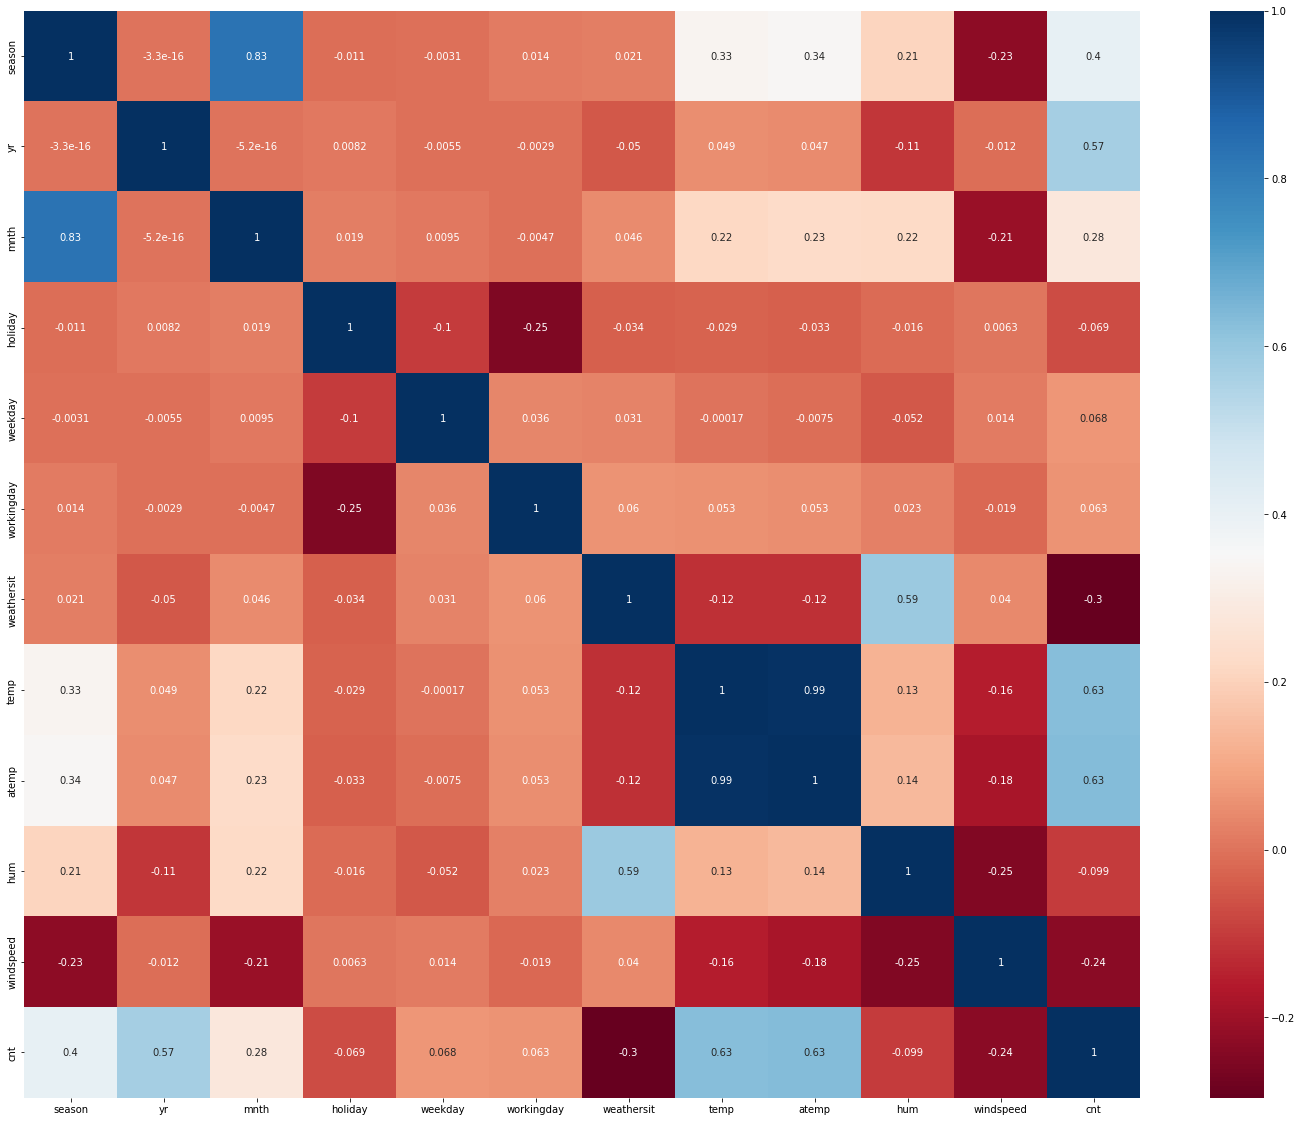

In [283]:
plt.figure(figsize = (25,20))
sns.heatmap(bike.corr(), annot = True, cmap="RdBu")
plt.show()

Inference 
- You can see high cor-relation between certain variables.
- cnt is most cor-related with temp, atemp, yr.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

## Step 3 - Data preparation and processing. 
Create dummy variables for categorical data
- Some columns like weathersit, season, month, weekday seem to be categorical but have int/float values

In [284]:
# check types
# Check the datatypes before conversion
bike.info()
# Inference
# mnth is int64
# weekday is int64
# weathersit is int64
# season is int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


Convert weathersit and season to categorical variables

In [285]:
# convert weathersit and season to actual string values from data dictionary
weathersit={1:'Clear',2:'Mist',3:'Light_Snow',4:'Heavy_Rain'}
season={1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
bike['weathersit']=bike['weathersit'].replace(weathersit)
bike['season']=bike['season'].replace(season)
bike.head()
bike.info()
# inference - type has changed to object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 68.6+ KB


Do Type Conversion of mnth and weekday

In [286]:
bike['mnth']=bike['mnth'].astype('category')
bike['weekday']=bike['weekday'].astype('category')
# check types
bike.info()
# inference - type has changed to category

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    object  
 1   yr          730 non-null    int64   
 2   mnth        730 non-null    category
 3   holiday     730 non-null    int64   
 4   weekday     730 non-null    category
 5   workingday  730 non-null    int64   
 6   weathersit  730 non-null    object  
 7   temp        730 non-null    float64 
 8   atemp       730 non-null    float64 
 9   hum         730 non-null    float64 
 10  windspeed   730 non-null    float64 
 11  cnt         730 non-null    int64   
dtypes: category(2), float64(4), int64(4), object(2)
memory usage: 59.3+ KB


Get dummies and remove source columns for weathersit, season, mnt, and weekday

In [287]:
bike = pd.get_dummies(bike, drop_first=True)
bike.info()
print(bike.shape)
# inference
# created dummies for categorical variables
# - # of columns increased to 30

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   yr                     730 non-null    int64  
 1   holiday                730 non-null    int64  
 2   workingday             730 non-null    int64  
 3   temp                   730 non-null    float64
 4   atemp                  730 non-null    float64
 5   hum                    730 non-null    float64
 6   windspeed              730 non-null    float64
 7   cnt                    730 non-null    int64  
 8   season_Spring          730 non-null    uint8  
 9   season_Summer          730 non-null    uint8  
 10  season_Winter          730 non-null    uint8  
 11  mnth_2                 730 non-null    uint8  
 12  mnth_3                 730 non-null    uint8  
 13  mnth_4                 730 non-null    uint8  
 14  mnth_5                 730 non-null    uint8  
 15  mnth_6

## Step 4: Splitting the Data into Training and Testing Sets

As you know, the first basic step for regression is performing a train-test split.

In [288]:
# We specify this so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(bike, train_size = 0.7, test_size = 0.3, random_state = 42)
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Light_Snow,weathersit_Mist
683,1,0,1,13.188347,16.22460,62.0417,10.250129,5445,0,0,...,1,0,0,0,0,1,0,0,0,1
645,1,1,0,15.716653,19.38040,70.9583,12.708493,5478,0,0,...,0,0,1,0,0,0,0,0,0,1
163,0,0,1,26.035000,30.08270,49.4583,20.458450,5020,0,1,...,0,0,1,0,0,0,0,0,0,0
360,0,0,1,13.325000,16.38165,76.2500,12.626150,1162,1,0,...,0,1,0,1,0,0,0,0,0,1
640,1,0,1,26.957500,29.95665,79.3750,4.458569,7572,0,0,...,0,0,0,0,1,0,0,0,0,1


### Rescaling the Features 
We are using Normalisation for this case study.

We could use standardisation as it is not affected by outliers.
Also, Standardisation is preferred for linear regression. However, the model I built with standardisation had negative constant and much lower Test R Squared value. So switching to Normalisation.

In [289]:
# scaler = StandardScaler()
scaler = MinMaxScaler()

In [290]:
# Apply scaler() to all the columns except the 'dummy' variables
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [291]:
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Light_Snow,weathersit_Mist
683,1,0,1,0.327133,0.322150,0.639330,0.327101,0.605336,0,0,...,1,0,0,0,0,1,0,0,0,1
645,1,1,0,0.403972,0.404998,0.731215,0.419004,0.609320,0,0,...,0,0,1,0,0,0,0,0,0,1
163,0,0,1,0.717562,0.685963,0.509660,0.708724,0.554026,0,1,...,0,0,1,0,0,0,0,0,0,0
360,0,0,1,0.331287,0.326273,0.785745,0.415925,0.088253,1,0,...,0,1,0,1,0,0,0,0,0,1
640,1,0,1,0.745598,0.682653,0.817947,0.110593,0.862127,0,0,...,0,0,0,0,1,0,0,0,0,1


In [292]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Light_Snow,weathersit_Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.521569,0.027451,0.668627,0.551091,0.526680,0.653801,0.414566,0.498206,0.231373,0.256863,...,0.092157,0.074510,0.149020,0.131373,0.139216,0.147059,0.129412,0.150980,0.029412,0.345098
std,0.500025,0.163554,0.471169,0.227401,0.213153,0.143542,0.185671,0.233905,0.422124,0.437332,...,0.289531,0.262857,0.356457,0.338139,0.346511,0.354512,0.335985,0.358381,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.354176,0.352585,0.544033,0.281934,0.345950,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.575824,0.564951,0.659296,0.383964,0.502233,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.745338,0.698389,0.756762,0.525698,0.677080,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dividing into X and Y sets for the model building

In [293]:
y_train = df_train.pop('cnt')
X_train = df_train

## Step 5: Building a linear model
### Model 1 - with all parameters using statsmodel


### Adding all the variables to the model

In [294]:
# Check all the columns of the dataframe
bike.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'cnt', 'season_Spring', 'season_Summer', 'season_Winter', 'mnth_2',
       'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9',
       'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_Light_Snow',
       'weathersit_Mist'],
      dtype='object')

In [295]:
#Build a linear model
lr_1 = build_model_print_statistics(X_train,y_train)

const                    0.284527
yr                       0.235660
holiday                 -0.036045
workingday               0.038774
temp                     0.185522
atemp                    0.274608
hum                     -0.164098
windspeed               -0.112761
season_Spring           -0.147200
season_Summer            0.011215
season_Winter            0.076822
mnth_2                   0.015068
mnth_3                   0.054091
mnth_4                  -0.002321
mnth_5                   0.029458
mnth_6                  -0.000285
mnth_7                  -0.043627
mnth_8                  -0.011466
mnth_9                   0.073623
mnth_10                  0.036476
mnth_11                 -0.052827
mnth_12                 -0.040203
weekday_1               -0.006634
weekday_2               -0.014636
weekday_3                0.004460
weekday_4                0.006372
weekday_5                0.013167
weekday_6                0.047204
weathersit_Light_Snow   -0.227039
weathersit_Mis

Looking at the p-values, it looks like some of the variables aren't really significant (in the presence of other variables).

Maybe we could drop some?

We could simply drop the variable with the highest, non-significant p value. A better way would be to supplement this with the VIF information. 

### Checking VIF

Variance Inflation Factor or VIF, gives a basic quantitative idea about how much the feature variables are correlated with each other. It is an extremely important parameter to test our linear model. The formula for calculating `VIF` is:

### $ VIF_i = \frac{1}{1 - {R_i}^2} $

In [296]:
print_vif(X_train)

                 Features      VIF
24              weekday_4      inf
25              weekday_5      inf
21              weekday_1      inf
1                 holiday      inf
23              weekday_3      inf
22              weekday_2      inf
2              workingday      inf
3                    temp  1505.39
4                   atemp  1433.68
5                     hum    32.46
8           season_Summer     9.38
9           season_Winter     8.99
15                 mnth_7     8.71
13                 mnth_5     7.88
14                 mnth_6     7.63
6               windspeed     7.15
7           season_Spring     6.89
16                 mnth_8     6.70
17                 mnth_9     6.29
18                mnth_10     6.07
12                 mnth_4     6.01
19                mnth_11     5.23
20                mnth_12     2.76
28        weathersit_Mist     2.32
11                 mnth_3     2.30
0                      yr     2.15
26              weekday_6     1.93
10                 m

We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

An infinite VIF value indicates that the corresponding variable may be expressed exactly by a linear combination of other variables.

Dropping weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, workingday, holiday

### Dropping the variable and updating the model

In [297]:
# Dropping highly correlated variables and insignificant variables
X = X_train.drop(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'workingday', 'holiday'], 1)

In [298]:
# Build a second fitted model
lr_2 = build_model_print_statistics(X,y_train)

const                    0.327738
yr                       0.235141
temp                     0.116750
atemp                    0.362232
hum                     -0.178723
windspeed               -0.115200
season_Spring           -0.158795
season_Summer            0.005722
season_Winter            0.077694
mnth_2                   0.015130
mnth_3                   0.055082
mnth_4                  -0.011236
mnth_5                   0.023280
mnth_6                  -0.007826
mnth_7                  -0.060044
mnth_8                  -0.021470
mnth_9                   0.061133
mnth_10                  0.021212
mnth_11                 -0.064977
mnth_12                 -0.049328
weekday_6                0.017874
weathersit_Light_Snow   -0.216246
weathersit_Mist         -0.055075
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. 

In [299]:
# Calculate the VIFs again for the new model
print_vif(X)

                 Features      VIF
1                    temp  1460.05
2                   atemp  1392.29
3                     hum    31.78
6           season_Summer     9.31
7           season_Winter     8.87
13                 mnth_7     8.66
11                 mnth_5     7.85
12                 mnth_6     7.54
4               windspeed     7.06
14                 mnth_8     6.63
5           season_Spring     6.62
15                 mnth_9     6.26
16                mnth_10     6.03
10                 mnth_4     5.98
17                mnth_11     5.18
18                mnth_12     2.74
21        weathersit_Mist     2.30
9                  mnth_3     2.29
0                      yr     2.14
8                  mnth_2     1.87
20  weathersit_Light_Snow     1.33
19              weekday_6     1.20


### Dropping the Variables and Updating the Model

As you can notice some of the variable have high VIF values as well as high p-values. Such variables are insignificant and should be dropped.

- temp has high VIF and high p-value. However, from the business point of view temperature would be an important predictor. Based on domain knowledge not dropping temp yet.
- Removing the variable 'atemp' based on its High p-value & High VIF



In [300]:
# Dropping highly correlated variables and insignificant variables
X = X.drop('atemp', 1)

In [301]:
# Build a second fitted model
lr_3 = build_model_print_statistics(X,y_train)

const                    0.331292
yr                       0.234863
temp                     0.463922
hum                     -0.174989
windspeed               -0.125737
season_Spring           -0.159688
season_Summer            0.007128
season_Winter            0.078024
mnth_2                   0.016722
mnth_3                   0.056217
mnth_4                  -0.010131
mnth_5                   0.020226
mnth_6                  -0.015246
mnth_7                  -0.065627
mnth_8                  -0.028736
mnth_9                   0.056355
mnth_10                  0.021630
mnth_11                 -0.063562
mnth_12                 -0.047365
weekday_6                0.017983
weathersit_Light_Snow   -0.221360
weathersit_Mist         -0.056036
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.833


In [302]:
# Calculate the VIFs again for the new model
print_vif(X)

                 Features    VIF
1                    temp  45.58
2                     hum  31.36
5           season_Summer   9.27
6           season_Winter   8.85
12                 mnth_7   8.61
10                 mnth_5   7.83
11                 mnth_6   7.43
4           season_Spring   6.61
13                 mnth_8   6.55
3               windspeed   6.41
14                 mnth_9   6.23
15                mnth_10   6.03
9                  mnth_4   5.97
16                mnth_11   5.16
17                mnth_12   2.72
20        weathersit_Mist   2.29
8                  mnth_3   2.28
0                      yr   2.14
7                  mnth_2   1.86
19  weathersit_Light_Snow   1.30
18              weekday_6   1.20


- Temp has high VIF, low p-value. Not dropping.
- hum has high VIF, low p-value. Not dropping.
- season_Summer has high VIF, high p-value. Dropping this variable



In [303]:
X = X.drop('season_Summer', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features    VIF
1                    temp  45.48
2                     hum  29.03
5           season_Winter   8.59
11                 mnth_7   8.43
10                 mnth_6   6.83
12                 mnth_8   6.39
3               windspeed   6.21
9                  mnth_5   6.07
13                 mnth_9   6.06
14                mnth_10   5.99
4           season_Spring   5.54
15                mnth_11   5.12
8                  mnth_4   4.36
16                mnth_12   2.72
19        weathersit_Mist   2.27
0                      yr   2.12
7                  mnth_3   2.03
6                  mnth_2   1.84
18  weathersit_Light_Snow   1.29
17              weekday_6   1.20


In [304]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.336090
yr                       0.234887
temp                     0.462315
hum                     -0.174855
windspeed               -0.125681
season_Spring           -0.164257
season_Winter            0.075721
mnth_2                   0.016853
mnth_3                   0.057483
mnth_4                  -0.007108
mnth_5                   0.023482
mnth_6                  -0.014092
mnth_7                  -0.069159
mnth_8                  -0.032378
mnth_9                   0.053146
mnth_10                  0.019871
mnth_11                 -0.065557
mnth_12                 -0.048574
weekday_6                0.017879
weathersit_Light_Snow   -0.221435
weathersit_Mist         -0.055962
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squa

Dropping mnth_6 as it has high p-value and high VIF

In [305]:
X = X.drop('mnth_6', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features    VIF
2                     hum  28.64
1                    temp  19.81
5           season_Winter   8.26
3               windspeed   5.97
4           season_Spring   4.43
14                mnth_11   4.21
13                mnth_10   4.15
15                mnth_12   2.33
18        weathersit_Mist   2.27
10                 mnth_7   2.12
0                      yr   2.12
12                 mnth_9   1.98
9                  mnth_5   1.89
8                  mnth_4   1.83
11                 mnth_8   1.80
6                  mnth_2   1.70
7                  mnth_3   1.37
17  weathersit_Light_Snow   1.29
16              weekday_6   1.19


In [306]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.329663
yr                       0.235199
temp                     0.452866
hum                     -0.172598
windspeed               -0.125530
season_Spring           -0.158772
season_Winter            0.078617
mnth_2                   0.019196
mnth_3                   0.063077
mnth_4                   0.002720
mnth_5                   0.034595
mnth_7                  -0.056147
mnth_8                  -0.019935
mnth_9                   0.063802
mnth_10                  0.026926
mnth_11                 -0.059899
mnth_12                 -0.044506
weekday_6                0.017811
weathersit_Light_Snow   -0.222065
weathersit_Mist         -0.056393
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                

Dropping hum due to high VIF. Not dropping temp as it has business value

In [307]:
X = X.drop('hum', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
1                    temp  8.39
4           season_Winter  7.83
2               windspeed  5.95
12                mnth_10  4.10
13                mnth_11  4.04
3           season_Spring  2.86
14                mnth_12  2.21
9                  mnth_7  2.12
0                      yr  2.11
11                 mnth_9  1.88
10                 mnth_8  1.78
8                  mnth_5  1.71
5                  mnth_2  1.70
7                  mnth_4  1.61
17        weathersit_Mist  1.59
6                  mnth_3  1.36
15              weekday_6  1.19
16  weathersit_Light_Snow  1.11


In [308]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.235377
yr                       0.240497
temp                     0.425788
windspeed               -0.094174
season_Spring           -0.167151
season_Winter            0.075552
mnth_2                   0.018865
mnth_3                   0.064525
mnth_4                  -0.002910
mnth_5                   0.022181
mnth_7                  -0.055785
mnth_8                  -0.025332
mnth_9                   0.050382
mnth_10                  0.015612
mnth_11                 -0.069191
mnth_12                 -0.055806
weekday_6                0.017893
weathersit_Light_Snow   -0.272363
weathersit_Mist         -0.083553
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     137.3
Date:                Fr

Dropping season_Winter due to high VIF value.

In [309]:
X = X.drop('season_Winter', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
1                    temp  8.39
2               windspeed  5.93
3           season_Spring  2.63
8                  mnth_7  2.12
0                      yr  2.11
9                  mnth_8  1.78
10                 mnth_9  1.75
7                  mnth_5  1.70
4                  mnth_2  1.65
6                  mnth_4  1.60
16        weathersit_Mist  1.58
11                mnth_10  1.52
12                mnth_11  1.38
5                  mnth_3  1.35
13                mnth_12  1.28
14              weekday_6  1.19
15  weathersit_Light_Snow  1.11


In [310]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.269462
yr                       0.240744
temp                     0.391951
windspeed               -0.099100
season_Spring           -0.196347
mnth_2                   0.026535
mnth_3                   0.065039
mnth_4                  -0.016798
mnth_5                   0.012649
mnth_7                  -0.058835
mnth_8                  -0.030353
mnth_9                   0.061633
mnth_10                  0.077459
mnth_11                 -0.012498
mnth_12                 -0.019447
weekday_6                0.015367
weathersit_Light_Snow   -0.273291
weathersit_Mist         -0.083048
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                     142.6
Date:                Fri, 18 Nov 2022   Prob (F-statistic

Dropping mnth_11 for high p-value

In [311]:
X = X.drop('mnth_11', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
1                    temp  8.23
2               windspeed  5.42
3           season_Spring  2.48
0                      yr  2.08
8                  mnth_7  1.95
4                  mnth_2  1.65
9                  mnth_8  1.65
10                 mnth_9  1.61
15        weathersit_Mist  1.58
7                  mnth_5  1.55
6                  mnth_4  1.44
11                mnth_10  1.40
5                  mnth_3  1.32
12                mnth_12  1.24
13              weekday_6  1.18
14  weathersit_Light_Snow  1.11


In [312]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.257786
yr                       0.240589
temp                     0.402535
windspeed               -0.098727
season_Spring           -0.189537
mnth_2                   0.028025
mnth_3                   0.067724
mnth_4                  -0.010811
mnth_5                   0.017060
mnth_7                  -0.056411
mnth_8                  -0.027363
mnth_9                   0.065660
mnth_10                  0.083154
mnth_12                 -0.014206
weekday_6                0.015570
weathersit_Light_Snow   -0.272882
weathersit_Mist         -0.082772
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     151.7
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.27e-178
Time:       

Dropping mnth_4 for high p-value

In [313]:
X = X.drop('mnth_4', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
1                    temp  8.06
2               windspeed  4.95
3           season_Spring  2.37
0                      yr  2.07
7                  mnth_7  1.82
4                  mnth_2  1.64
14        weathersit_Mist  1.57
8                  mnth_8  1.54
9                  mnth_9  1.50
6                  mnth_5  1.43
5                  mnth_3  1.30
10                mnth_10  1.30
11                mnth_12  1.21
12              weekday_6  1.18
13  weathersit_Light_Snow  1.11


In [314]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.255422
yr                       0.240553
temp                     0.403392
windspeed               -0.101458
season_Spring           -0.186894
mnth_2                   0.028852
mnth_3                   0.069396
mnth_5                   0.020050
mnth_7                  -0.053742
mnth_8                  -0.024585
mnth_9                   0.068494
mnth_10                  0.086179
mnth_12                 -0.012011
weekday_6                0.015611
weathersit_Light_Snow   -0.273186
weathersit_Mist         -0.082960
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     162.0
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.17e-179
Time:                        15:44:40   Log-Li

Dropping mnth_12 for high p-value

In [315]:
X = X.drop('mnth_12', 1)
# Calculate the VIFs again for the new model
print_vif(X)

                 Features   VIF
1                    temp  8.03
2               windspeed  4.95
3           season_Spring  2.29
0                      yr  2.05
7                  mnth_7  1.80
4                  mnth_2  1.57
13        weathersit_Mist  1.54
8                  mnth_8  1.53
9                  mnth_9  1.47
6                  mnth_5  1.41
10                mnth_10  1.28
5                  mnth_3  1.25
11              weekday_6  1.18
12  weathersit_Light_Snow  1.09


In [316]:
# Build another fitted model
lr_4 = build_model_print_statistics(X,y_train)

const                    0.250933
yr                       0.240201
temp                     0.407554
windspeed               -0.099310
season_Spring           -0.186949
mnth_2                   0.031507
mnth_3                   0.071765
mnth_5                   0.021298
mnth_7                  -0.053271
mnth_8                  -0.023893
mnth_9                   0.069729
mnth_10                  0.088144
weekday_6                0.015627
weathersit_Light_Snow   -0.274959
weathersit_Mist         -0.083506
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     173.7
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.09e-180
Time:                        15:44:40   Log-Likelihood:                 470.97
N

### Inference
- temp VIF value has dropped.
- The Adj. R- squared is 82%. 
- Some more predictors could be dropped owing to high p-values and high VIF. 
- However, in the next approach we will use RFE and Manual elimination to see if that creates a better model.

## Model 2 - Building model with a combination of RFE and manual elimination

In [317]:
# Running RFE with the output number of the variable equal to 15
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(estimator=lm, n_features_to_select=15)  # running RFE
rfe = rfe.fit(X_train, y_train)

In [318]:
# print RFE results
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

# Difference from manual elimination
# RFE is removing temp,

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', False, 12),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', False, 15),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('mnth_2', False, 11),
 ('mnth_3', False, 5),
 ('mnth_4', False, 6),
 ('mnth_5', False, 4),
 ('mnth_6', False, 7),
 ('mnth_7', False, 8),
 ('mnth_8', False, 2),
 ('mnth_9', True, 1),
 ('mnth_10', True, 1),
 ('mnth_11', False, 10),
 ('mnth_12', False, 14),
 ('weekday_1', True, 1),
 ('weekday_2', True, 1),
 ('weekday_3', True, 1),
 ('weekday_4', True, 1),
 ('weekday_5', True, 1),
 ('weekday_6', False, 3),
 ('weathersit_Light_Snow', False, 13),
 ('weathersit_Mist', False, 9)]

In [319]:
# print only columns that RFE selewcted
col = X_train.columns[rfe.support_]
col

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed',
       'season_Summer', 'season_Winter', 'mnth_9', 'mnth_10', 'weekday_1',
       'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5'],
      dtype='object')

In [320]:
# print columns not selected by RFE
X_train.columns[~rfe.support_]

Index(['temp', 'season_Spring', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_11', 'mnth_12', 'weekday_6',
       'weathersit_Light_Snow', 'weathersit_Mist'],
      dtype='object')

In [321]:
# Creating X_test dataframe with RFE selected variables
X_train_rfe = X_train[col]

#### Building model using statsmodel for detailed statistics

In [322]:
print_vif(X_train_rfe)

         Features    VIF
1         holiday    inf
2      workingday    inf
10      weekday_1    inf
11      weekday_2    inf
12      weekday_3    inf
13      weekday_4    inf
14      weekday_5    inf
4             hum  11.20
3           atemp   7.65
5       windspeed   4.46
7   season_Winter   2.17
0              yr   2.03
6   season_Summer   1.66
9         mnth_10   1.63
8          mnth_9   1.25


In [323]:
lr_rfe_1 = build_model_print_statistics(X_train_rfe,y_train)

const            0.239217
yr               0.230933
holiday         -0.057337
workingday       0.021078
atemp            0.668246
hum             -0.350802
windspeed       -0.157184
season_Summer    0.094573
season_Winter    0.130703
mnth_9           0.123598
mnth_10          0.060472
weekday_1       -0.012581
weekday_2       -0.022823
weekday_3       -0.004142
weekday_4       -0.004826
weekday_5        0.008112
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     152.2
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          4.29e-169
Time:                        15:44:40   Log-Likelihood:                 443.31
No. Observations:                 510   AIC:                            -856.6
Df Residuals:   

We generally want a VIF that is less than 5. So there are clearly some variables we need to drop.

An infinite VIF value indicates that the corresponding variable may be expressed exactly by a linear combination of other variables.

Dropping weekday_1, weekday_2, weekday_3, weekday_4, weekday_5, workingday, holiday

In [324]:
# Dropping highly correlated variables and insignificant variables
X_train_rfe = X_train_rfe.drop(['weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'holiday'], 1)

In [325]:
print_vif(X_train_rfe)

        Features    VIF
3            hum  10.88
2          atemp   7.61
4      windspeed   4.44
1     workingday   2.97
6  season_Winter   2.16
0             yr   2.02
5  season_Summer   1.66
8        mnth_10   1.62
7         mnth_9   1.25


In [326]:
lr_rfe_2 = build_model_print_statistics(X_train_rfe,y_train)

const            0.233514
yr               0.231042
workingday       0.019430
atemp            0.671394
hum             -0.354218
windspeed       -0.156340
season_Summer    0.095045
season_Winter    0.131941
mnth_9           0.123871
mnth_10          0.058616
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     233.9
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          6.11e-173
Time:                        15:44:40   Log-Likelihood:                 438.74
No. Observations:                 510   AIC:                            -857.5
Df Residuals:                     500   BIC:                            -815.1
Df Model:                           9                                         
Covariance Typ

Predictor temp has business value, so adding that to the columns and removing atemp.

In [327]:
X_train_rfe = X_train_rfe.drop('atemp',1)
X_train_rfe['temp']=X_train['temp']
print_vif(X_train_rfe)

        Features    VIF
2            hum  10.65
8           temp   7.39
3      windspeed   4.45
1     workingday   2.97
5  season_Winter   2.17
0             yr   2.02
4  season_Summer   1.65
7        mnth_10   1.62
6         mnth_9   1.26


In [328]:
lr_rfe_3 = build_model_print_statistics(X_train_rfe,y_train)

const            0.245936
yr               0.231088
workingday       0.020149
hum             -0.351723
windspeed       -0.176396
season_Summer    0.100013
season_Winter    0.137094
mnth_9           0.122217
mnth_10          0.059938
temp             0.625716
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.807
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                     232.0
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          3.38e-172
Time:                        15:44:40   Log-Likelihood:                 436.99
No. Observations:                 510   AIC:                            -854.0
Df Residuals:                     500   BIC:                            -811.6
Df Model:                           9                                         
Covariance Typ

Dropping hum based on high VIF

In [329]:
X_train_rfe = X_train_rfe.drop('hum',1)
print_vif(X_train_rfe)

        Features   VIF
7           temp  4.86
2      windspeed  3.59
1     workingday  2.83
0             yr  2.00
4  season_Winter  1.94
3  season_Summer  1.64
6        mnth_10  1.62
5         mnth_9  1.25


In [330]:
lr_rfe_4 = build_model_print_statistics(X_train_rfe,y_train)

const            0.005694
yr               0.241721
workingday       0.020105
windspeed       -0.120057
season_Summer    0.093213
season_Winter    0.125530
mnth_9           0.097565
mnth_10          0.043844
temp             0.607093
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     204.6
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.69e-152
Time:                        15:44:40   Log-Likelihood:                 387.79
No. Observations:                 510   AIC:                            -757.6
Df Residuals:                     501   BIC:                            -719.5
Df Model:                           8                                         
Covariance Type:            nonrobust   

Dropping mnth_10 due to high p-value

In [331]:
X_train_rfe = X_train_rfe.drop('mnth_10',1)
print_vif(X_train_rfe)

        Features   VIF
6           temp  4.75
2      windspeed  3.58
1     workingday  2.82
0             yr  2.00
3  season_Summer  1.63
4  season_Winter  1.38
5         mnth_9  1.22


In [332]:
lr_rfe_4 = build_model_print_statistics(X_train_rfe,y_train)

const            0.001347
yr               0.242047
workingday       0.019300
windspeed       -0.118640
season_Summer    0.091842
season_Winter    0.141933
mnth_9           0.091250
temp             0.615960
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     231.8
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          8.38e-153
Time:                        15:44:40   Log-Likelihood:                 385.69
No. Observations:                 510   AIC:                            -755.4
Df Residuals:                     502   BIC:                            -721.5
Df Model:                           7                                         
Covariance Type:            nonrobust                             

Adjusted R squared has dropped to 76.
Lets add weathersit and see if that helps.

In [333]:
X_train_rfe['weathersit_Light_Snow']=X_train['weathersit_Light_Snow']
X_train_rfe['weathersit_Mist']=X_train['weathersit_Mist']
print_vif(X_train_rfe)

                Features   VIF
6                   temp  4.78
2              windspeed  3.79
1             workingday  2.84
0                     yr  2.02
3          season_Summer  1.65
8        weathersit_Mist  1.53
4          season_Winter  1.40
5                 mnth_9  1.22
7  weathersit_Light_Snow  1.08


In [334]:
# build another model
lr_rfe_5,X_train_lm = build_model_print_statistics(X_train_rfe,y_train)

const                    0.032053
yr                       0.239397
workingday               0.023509
windspeed               -0.090499
season_Summer            0.098688
season_Winter            0.152388
mnth_9                   0.100872
temp                     0.591560
weathersit_Light_Snow   -0.257941
weathersit_Mist         -0.081198
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     247.0
Date:                Fri, 18 Nov 2022   Prob (F-statistic):          1.05e-177
Time:                        15:44:40   Log-Likelihood:                 449.97
No. Observations:                 510   AIC:                            -879.9
Df Residuals:                     500   BIC:                            -837.6
Df Model:    

In [335]:
### Inference
# - adding WeatherSit has increased the R squared and F-Statistic
# - There are no predictors with high VIF values.
# - There are no predictors with high p-value.
# - The Adj R squared value is 81%.

## Final Model Interpretation
### Hypothesis Testing:
- Hypothesis testing states that:

- H0:B1=B2=...=Bn=0
- H1: at least one Bi!=0

- From the model co-efficients we can reject the null hypothesis

### F Statistics

- F-Statistics is used for testing the overall significance of the Model: Higher the F-Statistics, more significant the Model is.

- F-statistic: 247.5
- Prob (F-statistic): 1.05e-177

The F-Statistics value of 247.5 (which is greater than 1) and the p-value of '~0.0000' states that the overall model is significant

## Validate Assumptions of Linear Regression
### Step 7: Residual Analysis of the train data

So, now to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

In [336]:
y_train_cnt = lr_rfe_5.predict(X_train_lm)

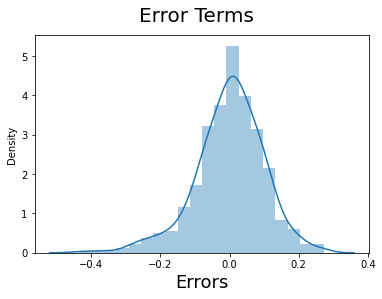

In [353]:
# Plot the histogram of the error terms
fig = plt.figure()
sns.distplot((y_train - y_train_cnt), bins = 20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)                         # X-label
plt.savefig('assumption1')

Inference:
- Error terms are normally distributed.

### Assumption 2: There is a linear relationship between X and Y

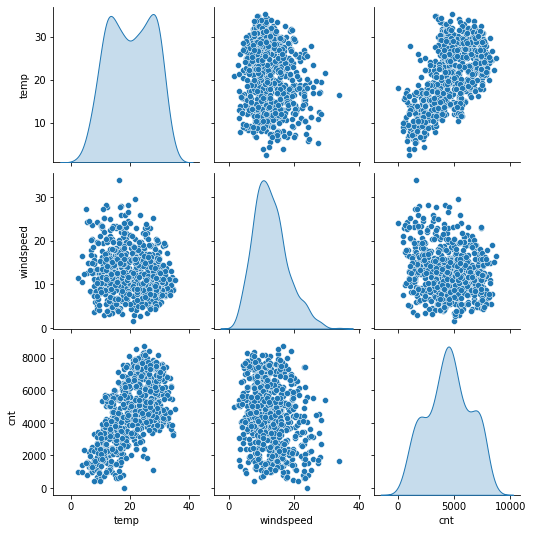

In [352]:
bike_temp=bike[[ 'temp', 'windspeed','cnt']]
sns.pairplot(bike_temp, diag_kind='kde')
plt.savefig('assumption2')
plt.show()

We can see that there is a linear relationship between temp and cnt

### Assumption 3: There is No Multicollinearity between the predictor variables

In [354]:
print_vif(X_train_rfe)

                Features   VIF
6                   temp  4.78
2              windspeed  3.79
1             workingday  2.84
0                     yr  2.02
3          season_Summer  1.65
8        weathersit_Mist  1.53
4          season_Winter  1.40
5                 mnth_9  1.22
7  weathersit_Light_Snow  1.08


All the VIF values are less than 5, so there is no Multicollinearity

## Assumption 4 - Observations are independent of each other.

Low p-value of all the predictors in the final model indicate that the observations are independent of each other.

## Step 8: Making Predictions Using the Final Model

Now that we have fitted the model and checked the normality of error terms, it's time to go ahead and make predictions using the final, i.e. fourth model.

#### Applying the scaling on the test sets

In [338]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed','cnt']
df_test[num_vars] = scaler.transform(df_test[num_vars])

In [339]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_Light_Snow,weathersit_Mist
count,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,...,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000,219.000000
mean,0.452055,0.031963,0.716895,0.527468,0.501760,0.629546,0.435511,0.479553,0.283105,0.237443,...,0.059361,0.109589,0.132420,0.168950,0.141553,0.132420,0.173516,0.127854,0.027397,0.315068
std,0.498836,0.176306,0.451539,0.229936,0.215759,0.152584,0.212750,0.233091,0.451539,0.426491,...,0.236840,0.313092,0.339723,0.375566,0.349389,0.339723,0.379560,0.334692,0.163612,0.465607
min,0.000000,0.000000,0.000000,0.047675,0.051010,0.193646,0.060760,-0.049378,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.324018,0.314694,0.520479,0.281156,0.285826,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.507811,0.496145,0.608416,0.416900,0.471206,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.726388,0.685028,0.735901,0.534288,0.644151,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,0.970925,0.939531,1.002146,1.214955,0.980804,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Dividing into X_test and y_test

In [340]:
y_test = df_test.pop('cnt')
X_test = df_test

In [341]:
# Adding constant variable to test dataframe
X_test_hyb = sm.add_constant(X_test)
# dropping unnecessary columns
X_test_new= X_test_hyb[X_train_lm.columns]
X_test_new.head()


,const,yr,workingday,windspeed,season_Summer,season_Winter,mnth_9,temp,weathersit_Light_Snow,weathersit_Mist
468,1.0,1,0,0.422104,1,0,0,0.543115,0,0
148,1.0,0,0,0.479765,1,0,0,0.758058,0,0
302,1.0,0,0,0.386287,0,1,0,0.324018,0,0
355,1.0,0,1,0.062325,0,0,0,0.453814,0,1
515,1.0,1,1,0.433030,1,0,0,0.773634,0,0


In [342]:
X_test_new.columns

Index(['const', 'yr', 'workingday', 'windspeed', 'season_Summer',
       'season_Winter', 'mnth_9', 'temp', 'weathersit_Light_Snow',
       'weathersit_Mist'],
      dtype='object')

In [343]:
# Making predictions using the hybrid model
y_pred_hyb = lr_rfe_5.predict(X_test_new)

## Step 9: Model Evaluation

Let's now plot the graph for actual versus predicted values.

Text(0, 0.5, 'y_pred')

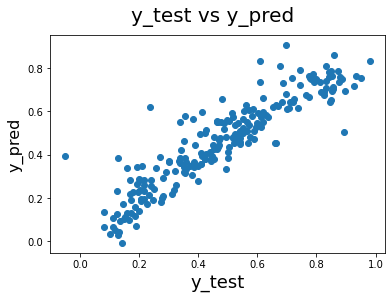

In [344]:
# Plotting y_test and y_pred to understand the spread
fig = plt.figure()
plt.scatter(y_test, y_pred_hyb)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_pred', fontsize = 16)  

In [345]:
lr_rfe_5.params

const                    0.032053
yr                       0.239397
workingday               0.023509
windspeed               -0.090499
season_Summer            0.098688
season_Winter            0.152388
mnth_9                   0.100872
temp                     0.591560
weathersit_Light_Snow   -0.257941
weathersit_Mist         -0.081198
dtype: float64


We can see that the equation of our best fitted line is:

cnt = `0.032` + `0.239 * yr` + `0.023 * workingday` - `0.090 * windspeed` + `0.098688 * season_Summer` + `0.152388 * season_Winter` + `0.100872 * mnth_9` + `0.591560 * temp` - `0.257941 * weathersit_Light_Snow` - `0.081198 * weathersit_Mist`      


### Interpretation of Co-efficients
- temp
  - A coefficient value of ‘0.591560’ indicated that a unit increase in temp variable, increases the bike hire numbers by 0.591560 units.
- yr
  - A coefficient value of ‘0.239’ indicated that a unit increase in yr variable, increases the bike hire numbers by 0.239 units.
- workingday
  - A coefficient value of ‘0.023’ indicated that, a unit increase in workingday variable increases the bike hire numbers by 0.023 units.
- windspeed
  - A coefficient value of ‘-0.090499’ indicated that, a unit increase in workingday variable decreases the bike hire numbers by 0.090499 units.
- season_Summer
  - A coefficient value of ‘0.098688’ indicated that w.r.t season_Fall, a unit increase in season_Spring variable decreases the bike hire numbers by 0.098688 units.
- season_Winter
  - A coefficient value of ‘0.152388’ indicated that w.r.t season_Fall, a unit increase in season_Spring variable increases the bike hire numbers by 0.152388 units.
- mnth_9
  - A coefficient value of ‘0.100872’ indicated that w.r.t mnth_1, a unit increase in mnth_9 variable increases the bike hire numbers by 0.100872 units.
- weathersit_Light_Snow
  - A coefficient value of ‘- 0.257941’ indicated that, w.r.t Weathersit_Spring, a unit increase in weathersit_Light_Snow variable, decreases the bike hire numbers by 0.257941 units.
- weathersit_Mist
  - A coefficient value of ‘- 0.081198’ indicated that, w.r.t Weathersit_Spring, a unit increase in weathersit_Mist variable, decreases the bike hire numbers by 0.081198 units.

R2 Score of Test Set

In [346]:
r2 = r2_score(y_test, y_pred_hyb)
r2

0.8159879529484231

In [347]:
# n is number of rows in X
n = X_test.shape[0]
# Number of features (predictors, p) is the shape along axis 1
p = X_test.shape[1]
#display adjusted R-squared
adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
adjusted_r2

0.7877533002262235

## Results

- Training R2 - 0.831
- Training Adjusted R2 - 0.827
- Testing R2 - 0.815
- Testing Adjusted R2 - 0.787

- Looks like the model can generalise on the test data

In [348]:
lr_rfe_5.params.sort_values()

weathersit_Light_Snow   -0.257941
windspeed               -0.090499
weathersit_Mist         -0.081198
workingday               0.023509
const                    0.032053
season_Summer            0.098688
mnth_9                   0.100872
season_Winter            0.152388
yr                       0.239397
temp                     0.591560
dtype: float64

## Final Report

- As per our final Model, the top 3 predictor variables that influences the bike booking positively are:

  - Temperature
  - Year
  - Winter

- The predictors that influences the bike booking negatively
  - Light Snow
  - WindSpeed
  - Mist